In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from pyspark.ml.feature import StringIndexer

In [2]:
spark = SparkSession.builder.appName("FlightPriceEDA").getOrCreate() 
spark.conf.set("spark.sql.legacy.timeParserPolicy", "CORRECTED")
spark.sparkContext

<SparkContext master=yarn appName=PySparkShell>

In [3]:
price_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group7_Final_Project/flight_pricing/preprocessed_prices.parquet", 
                                     header=True, inferSchema=True)

In [4]:
price_df.printSchema()

root
 |-- flight_date: date (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- fare_basis_code: string (nullable = true)
 |-- travel_duration: string (nullable = true)
 |-- elapsed_days: integer (nullable = true)
 |-- is_basic_economy: boolean (nullable = true)
 |-- is_refundable: boolean (nullable = true)
 |-- is_nonstop: boolean (nullable = true)
 |-- base_fare: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- seats_remaining: integer (nullable = true)
 |-- total_distance: integer (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- airline_name: string (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- equipment_description: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- cabin_code: string (nullable = true)
 |-- flight_year: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- flight_day:

Identifying missing data

In [5]:
missing_counts = price_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in price_df.columns])
columns_with_missing = [c for c in price_df.columns if price_df.filter(col(c).isNull()).count() > 0]

missing_counts.show()
print("Columns with missing values:", columns_with_missing)

23/11/17 21:45:25 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+------+-----------+---------------+---------------+------------+----------------+-------------+----------+---------+----------+---------------+--------------+--------------+------------+------------+------------+---------------------+--------+----------+-----------+------------+----------+-----------------------+-----------------------+---------+--------------------------+----------------------+----------------------+------------------------+------------------+--------------------+-----------+-----------------+
|flight_date|origin|destination|fare_basis_code|travel_duration|elapsed_days|is_basic_economy|is_refundable|is_nonstop|base_fare|total_fare|seats_remaining|total_distance|departure_time|arrival_time|airline_name|airline_code|equipment_description|distance|cabin_code|flight_year|flight_month|flight_day|travel_duration_minutes|travel_duration_seconds|num_stops|initial_departure_datetime|final_arrival_datetime|initial_departure_hour|initial_departure_minute|final_arriv

**General Overview:**
* What are the total number of records in this dataset?
* What is the distribution of boolean columns?
* What are the most popular origin and destination airports?

In [6]:
price_df.count()

82138753

In [7]:
nonnumeric_columns = ["flight_date",
                      "origin", 
                      "destination", 
                      "fare_basis_code", 
                      "travel_duration", 
                      "distance",
                      "departure_time",
                      "initial_departure_datetime",
                      "final_arrival_datetime",
                      "arrival_time",
                      "airline_name",
                      "airline_code",
                      "equipment_description",
                      "cabin_code",
                      "day_of_week"]

numeric_df = price_df.withColumn("is_basic_economy", col("is_basic_economy").cast("int"))
numeric_df = numeric_df.withColumn("is_refundable", col("is_refundable").cast("int"))
numeric_df = numeric_df.withColumn("is_nonstop", col("is_nonstop").cast("int"))

numeric_df = numeric_df.drop(*nonnumeric_columns)

numeric_df.printSchema()

root
 |-- elapsed_days: integer (nullable = true)
 |-- is_basic_economy: integer (nullable = true)
 |-- is_refundable: integer (nullable = true)
 |-- is_nonstop: integer (nullable = true)
 |-- base_fare: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- seats_remaining: integer (nullable = true)
 |-- total_distance: integer (nullable = true)
 |-- flight_year: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- flight_day: integer (nullable = true)
 |-- travel_duration_minutes: integer (nullable = true)
 |-- travel_duration_seconds: integer (nullable = true)
 |-- num_stops: integer (nullable = true)
 |-- initial_departure_hour: integer (nullable = true)
 |-- initial_departure_minute: integer (nullable = true)
 |-- final_arrival_hour: integer (nullable = true)
 |-- final_arrival_minute: integer (nullable = true)
 |-- day_of_week_index: integer (nullable = true)



In [8]:
numeric_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
elapsed_days,82138753,0.14965308762357277,0.3567567481729465,0,2
is_basic_economy,82138753,0.14396695308973098,0.3510562220046572,0,1
is_refundable,82138753,1.6216462404779873E-5,0.00402693427169495,0,1
is_nonstop,82138753,0.2686537985303965,0.44325944711604626,0,1
base_fare,82138753,292.6628527106407,183.18878337398374,0.01,7662.33
total_fare,82138753,340.38684915176736,196.0295099117071,19.59,8260.61
seats_remaining,82138753,5.976311522528228,2.880567111463767,0,10
total_distance,76044221,1609.9033457519408,857.3257345475645,89,7252
flight_year,82138753,2022.0,0.0,2022,2022


In [9]:
# sampled_data = numeric_df.sample(False, 0.8).toPandas()
# axs = pd.scatter_matrix(sampled_data, figsize=(10, 10))
# n = len(sampled_data.columns)
# for i in range(n):
#     v = axs[i, 0]
#     v.yaxis.label.set_rotation(0)
#     v.yaxis.label.set_ha('right')
#     v.set_yticks(())
#     h = axs[n-1, i]
#     h.xaxis.label.set_rotation(90)
#     h.set_xticks(())

In [10]:
import six
for i in numeric_df.columns:
    print( "Correlation to Total Fare for ", i, numeric_df.stat.corr('total_fare', i))

Correlation to Total Fare for  elapsed_days 0.1431791682919951


Correlation to Total Fare for  is_basic_economy -0.3379014138177334


Correlation to Total Fare for  is_refundable 0.01950812361493308


Correlation to Total Fare for  is_nonstop -0.2759080887543518


Correlation to Total Fare for  base_fare 0.9966886569717787


Correlation to Total Fare for  total_fare 1.0


Correlation to Total Fare for  seats_remaining 0.019818600477655803


Correlation to Total Fare for  total_distance 0.49627294986076165


Correlation to Total Fare for  flight_year nan


Correlation to Total Fare for  flight_month -0.1731025704212201


Correlation to Total Fare for  flight_day 0.013715137631670845


Correlation to Total Fare for  travel_duration_minutes 0.42691873559880217


Correlation to Total Fare for  travel_duration_seconds 0.4271626176624365


Correlation to Total Fare for  num_stops 0.3908533404167582


Correlation to Total Fare for  initial_departure_hour -0.025679112401017862


Correlation to Total Fare for  initial_departure_minute 0.013335615868445845


Correlation to Total Fare for  final_arrival_hour -0.08721838758166041


Correlation to Total Fare for  final_arrival_minute 0.0020465246900587073


Correlation to Total Fare for  day_of_week_index -0.03756258633984659


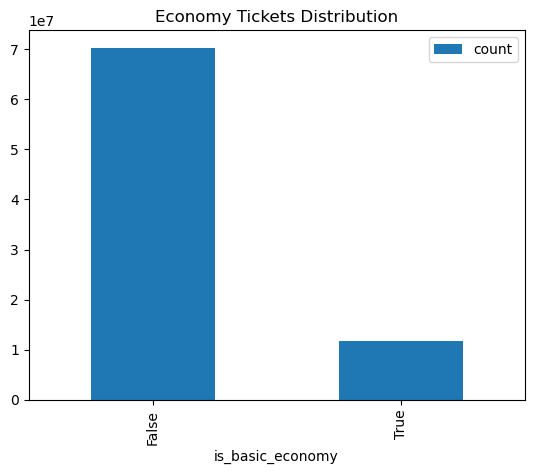

In [11]:
result_df = (price_df.groupBy('is_basic_economy')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df.plot(kind='bar', x='is_basic_economy', y='count', title='Economy Tickets Distribution')
plt.show()

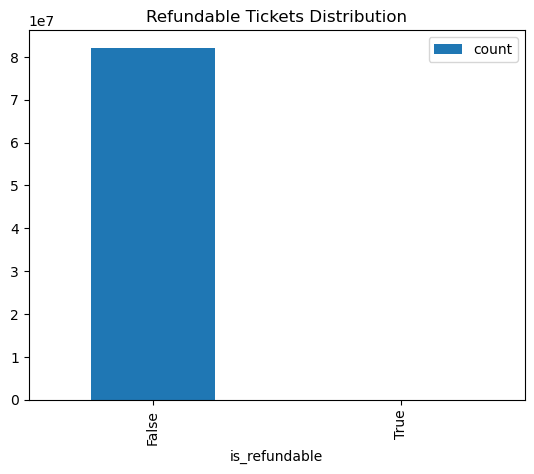

In [12]:
result_df = (price_df.groupBy('is_refundable')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df.plot(kind='bar', x='is_refundable', y='count', title='Refundable Tickets Distribution')
plt.show()

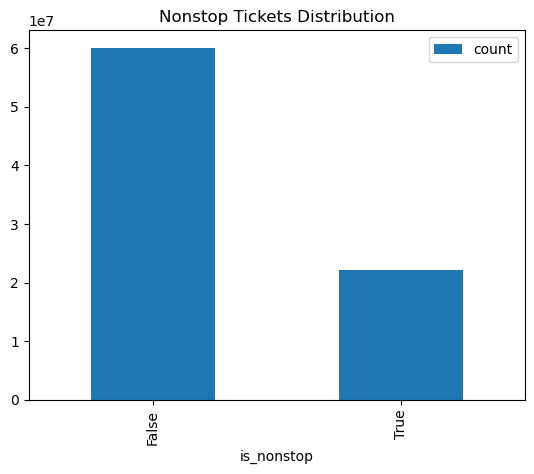

In [13]:
result_df = (price_df.groupBy('is_nonstop')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df.plot(kind='bar', x='is_nonstop', y='count', title='Nonstop Tickets Distribution')
plt.show()

In [14]:
result_df = (price_df.groupBy('fare_basis_code')
                     .count()
                     .orderBy('count', ascending = False)
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

Top Values:
  fare_basis_code    count
0        QAA0OKEN  1386883
1        KAUOA0MQ   937072
2        V7AWZNN1   797408
3        QAA0OFEN   570964
4        HAA0OKEN   537443

Bottom Values:
      fare_basis_code  count
21057        OVAIZRV1      1
21058        LA3TA0MQ      1
21059        UF7SA0ME      1
21060        UAUTH3BC      1
21061        HAU7AWEN      1


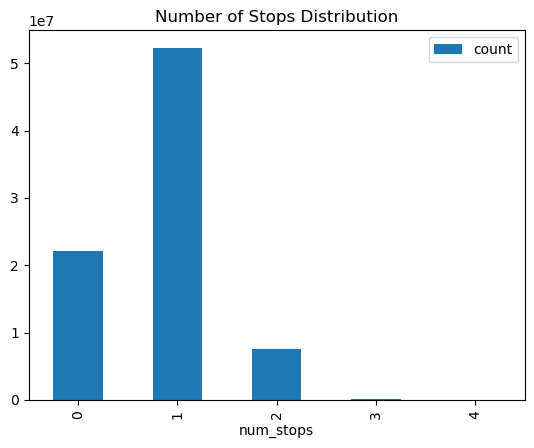

In [15]:
result_df = (price_df.groupBy('num_stops')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df = result_df.sort_values(by='num_stops')

result_df.plot(kind='bar', x='num_stops', y='count', title='Number of Stops Distribution')
plt.show()

Top Values:
  origin    count
0    LAX  8073281
1    LGA  5919323
2    BOS  5883876
3    SFO  5706482
4    DFW  5674959

Bottom Values:
   origin    count
11    DTW  4547052
12    JFK  4425164
13    EWR  3970797
14    OAK  3809884
15    IAD  3464378


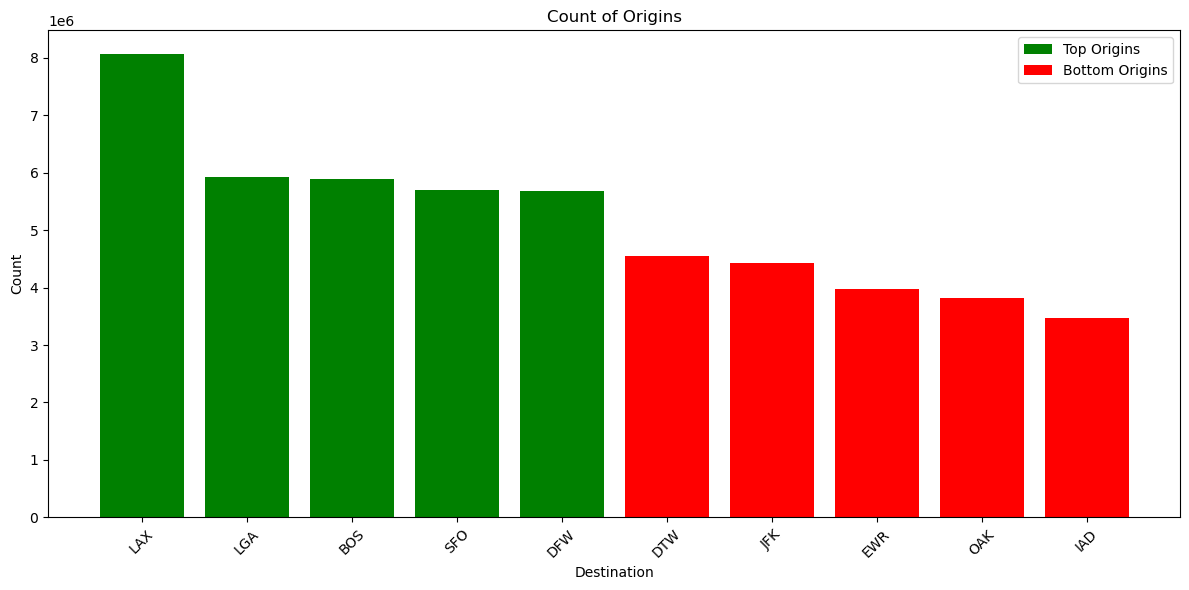

In [16]:
result_df = (price_df.groupBy('origin')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(12, 6))
plt.bar(top_values['origin'], top_values['count'], color='green', label='Top Origins')
plt.bar(bottom_values['origin'], bottom_values['count'], color='red', label='Bottom Origins')
plt.title('Count of Origins')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Top Values:
  destination    count
0         LAX  8006721
1         LGA  6093450
2         DFW  5957280
3         BOS  5801538
4         ORD  5717699

Bottom Values:
   destination    count
11         DTW  4456269
12         JFK  4413765
13         EWR  4074698
14         OAK  3657923
15         IAD  3312681


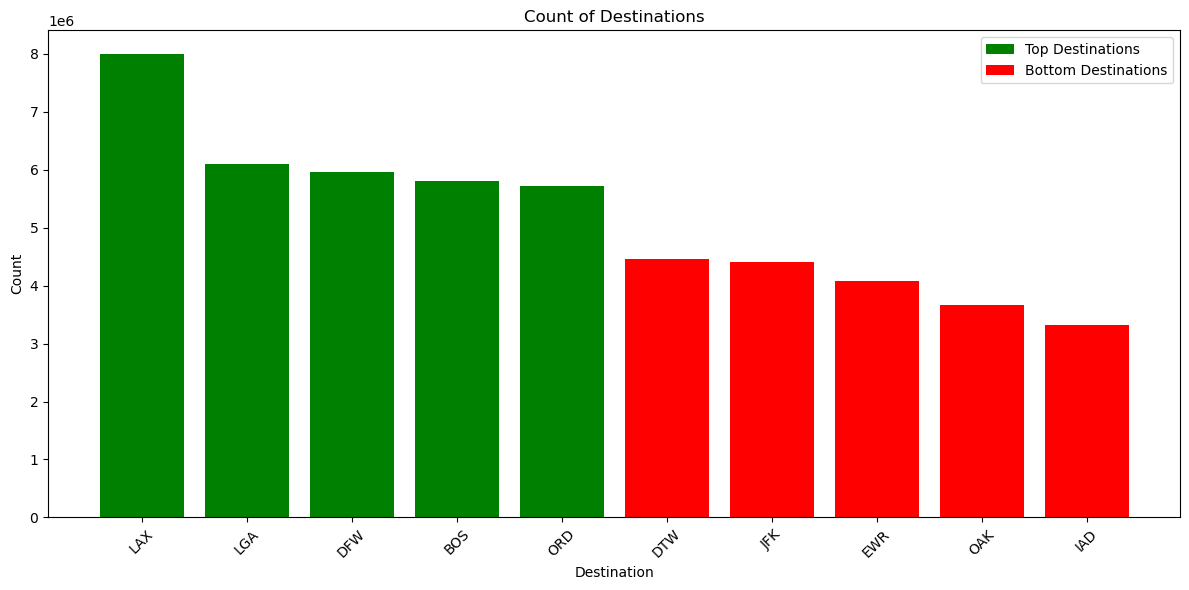

In [17]:
result_df = (price_df.groupBy('destination')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(12, 6))
plt.bar(top_values['destination'], top_values['count'], color='green', label='Top Destinations')
plt.bar(bottom_values['destination'], bottom_values['count'], color='red', label='Bottom Destinations')
plt.title('Count of Destinations')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Top Values:
  origin destination  route_count       route
0    ATL         LAX       709809  ATL to LAX
1    LAX         BOS       679169  LAX to BOS
2    LGA         LAX       677713  LGA to LAX
3    LAX         ATL       669609  LAX to ATL
4    LAX         LGA       663659  LAX to LGA

Bottom Values:
    origin destination  route_count       route
230    JFK         OAK       134545  JFK to OAK
231    CLT         IAD       128588  CLT to IAD
232    DTW         IAD       116469  DTW to IAD
233    IAD         DTW       108162  IAD to DTW
234    EWR         LGA           23  EWR to LGA


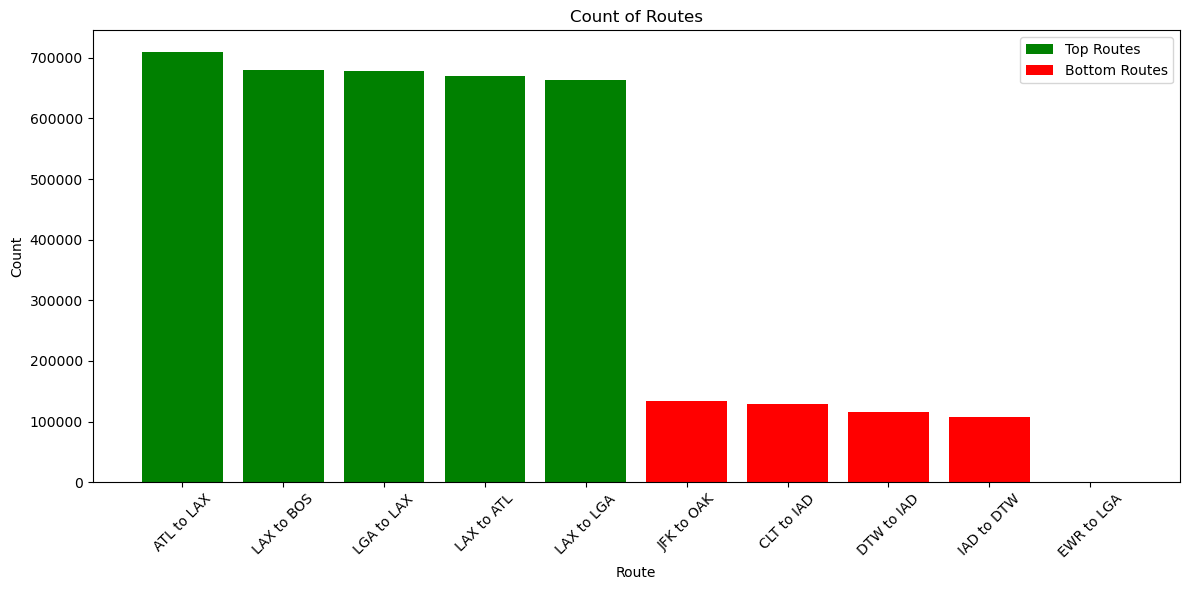

In [18]:
result_df = (price_df.groupBy("origin", "destination")
                     .agg(count("*").alias("route_count"))
                     .orderBy("route_count", ascending=False)
                     .toPandas())

result_df['route'] = result_df['origin'] + ' to ' + result_df['destination']

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(12, 6))
plt.bar(top_values['route'], top_values['route_count'], color='green', label='Top Routes')
plt.bar(bottom_values['route'], bottom_values['route_count'], color='red', label='Bottom Routes')
plt.title('Count of Routes')
plt.xlabel('Route')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Time Overview:**
* What is the time range? 
* What is the distribution of years, months, and days?
* What is the distribution of hours and minutes for departures and arrivals?

Top Values:
  flight_date   count
0  2022-08-30  729117
1  2022-09-07  695010
2  2022-09-13  690912
3  2022-09-08  671131
4  2022-08-31  667996

Bottom Values:
    flight_date  count
212  2022-11-18  36571
213  2022-04-19  30702
214  2022-11-19  21923
215  2022-04-18  16524
216  2022-04-17   8258


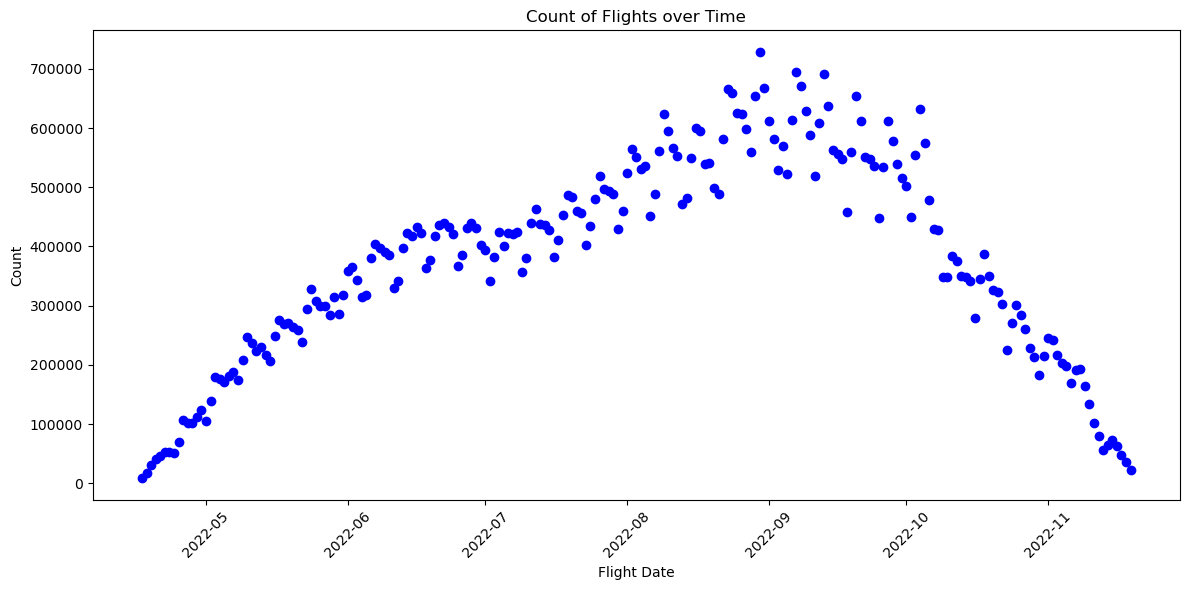

In [19]:
result_df = (price_df.groupBy('flight_date')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(12, 6))
plt.scatter(result_df['flight_date'], result_df['count'], marker='o', color='blue')
plt.title('Count of Flights over Time')
plt.xlabel('Flight Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
(price_df.groupBy('flight_year')
         .count()
         .orderBy('count', ascending=False)
         .toPandas())

,flight_year,count
0,2022,82138753


Top Values:
   flight_month     count month_name
0             8  17678497     August
1             9  17285217  September
2             7  13492890       July
3             6  11774933       June
4            10  11044671    October


<Figure size 1000x500 with 0 Axes>

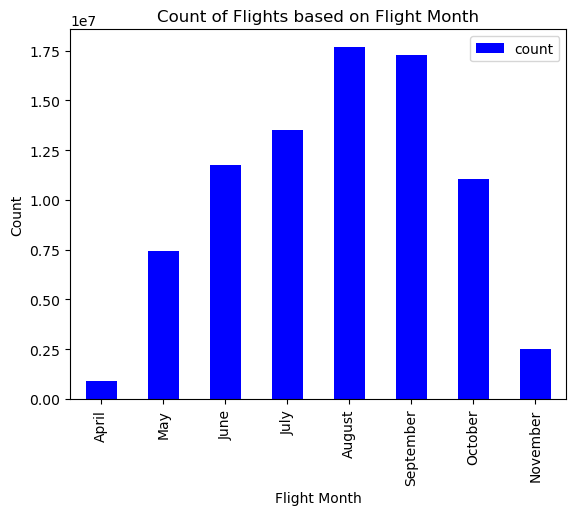

In [21]:
result_df = (price_df.groupBy('flight_month')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df['month_name'] = result_df['flight_month'].apply(lambda x: calendar.month_name[x])

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

result_df = result_df.sort_values(by='flight_month')

plt.figure(figsize=(10, 5))
result_df.plot(x='month_name', y='count', kind='bar', color='blue')
plt.title('Count of Flights based on Flight Month')
plt.xlabel('Flight Month')
plt.ylabel('Count')
plt.show()

Top Values:
  day_of_week  day_of_week_index     count
0     Tuesday                  2  13031728
1   Wednesday                  3  12667367
2    Thursday                  4  11959848
3      Monday                  1  11775547
4      Friday                  5  11660287
5    Saturday                  6  10726349
6      Sunday                  0  10317627


<Figure size 1000x500 with 0 Axes>

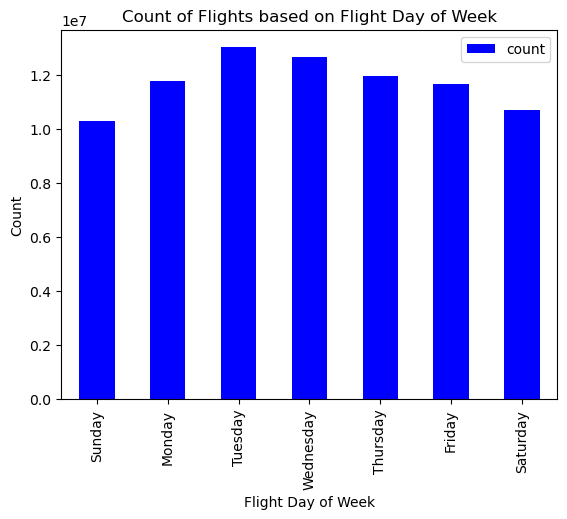

In [22]:
result_df = (price_df.groupBy('day_of_week', 'day_of_week_index')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(7)
print("Top Values:")
print(top_values)

result_df = result_df.sort_values(by='day_of_week_index')

plt.figure(figsize=(10, 5))
result_df.plot(x='day_of_week', y='count', kind='bar', color='blue')
plt.title('Count of Flights based on Flight Day of Week')
plt.xlabel('Flight Day of Week')
plt.ylabel('Count')
plt.show()

Top Values:
   initial_departure_hour    count
0                      12  7086803
1                      10  6409990
2                      13  5820011
3                      15  5761596
4                      14  5760430

Bottom Values:
    initial_departure_hour    count
19                       9  1436084
20                       3   668409
21                       4   542046
22                       7   364219
23                       8    32985


<Figure size 1000x500 with 0 Axes>

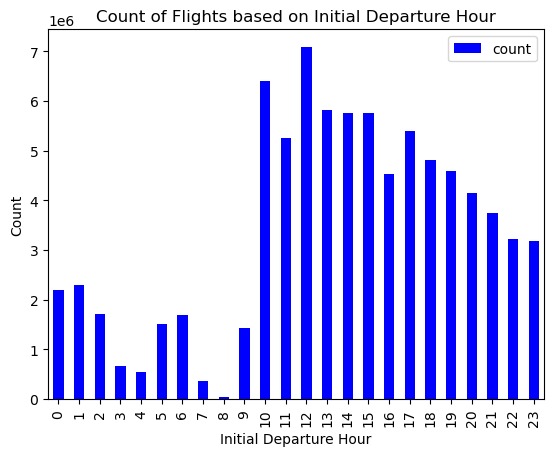

In [23]:
result_df = (price_df.groupBy('initial_departure_hour')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

result_df = result_df.sort_values(by='initial_departure_hour')

plt.figure(figsize=(10, 5))
result_df.plot(x='initial_departure_hour', y='count', kind='bar', color='blue')
plt.title('Count of Flights based on Initial Departure Hour')
plt.xlabel('Initial Departure Hour')
plt.ylabel('Count')
plt.show()

In [24]:
result_df = (price_df.groupBy('initial_departure_hour', 'initial_departure_minute')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df['combined_time'] = result_df['initial_departure_hour'].astype(str) + ':' + result_df['initial_departure_minute'].astype(str)

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

Top Values:
   initial_departure_hour  initial_departure_minute    count combined_time
0                      10                         0  2339642          10:0
1                      13                         0  1712442          13:0
2                      11                         0  1480409          11:0
3                      12                         0  1411815          12:0
4                      14                         0  1176921          14:0

Bottom Values:
      initial_departure_hour  initial_departure_minute  count combined_time
1357                       4                        56     17          4:56
1358                       7                        29     12          7:29
1359                       7                        14     10          7:14
1360                       9                         4     10           9:4
1361                       3                        53      8          3:53


Top Values:
   final_arrival_hour    count
0                   3  6100043
1                   1  5512890
2                  23  5481704
3                   2  5458371
4                  20  5148387

Bottom Values:
    final_arrival_hour    count
19                  11  1488078
20                  10   982649
21                   7   752023
22                   9   637350
23                   8   103602


<Figure size 1000x500 with 0 Axes>

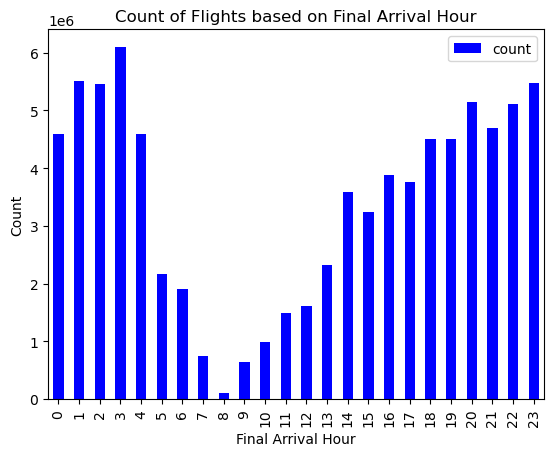

In [25]:
result_df = (price_df.groupBy('final_arrival_hour')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

result_df = result_df.sort_values(by='final_arrival_hour')

plt.figure(figsize=(10, 5))
result_df.plot(x='final_arrival_hour', y='count', kind='bar', color='blue')
plt.title('Count of Flights based on Final Arrival Hour')
plt.xlabel('Final Arrival Hour')
plt.ylabel('Count')
plt.show()

In [26]:
result_df = (price_df.groupBy('final_arrival_hour', 'final_arrival_minute')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df['combined_time'] = result_df['final_arrival_hour'].astype(str) + ':' + result_df['final_arrival_minute'].astype(str)

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

Top Values:
   final_arrival_hour  final_arrival_minute   count combined_time
0                   3                    59  457646          3:59
1                   5                    21  376465          5:21
2                   1                     5  343519           1:5
3                   3                    30  335772          3:30
4                  20                    50  281270         20:50

Bottom Values:
      final_arrival_hour  final_arrival_minute  count combined_time
1430                   8                     4     13           8:4
1431                   8                    53     10          8:53
1432                   8                    22      8          8:22
1433                   7                    49      6          7:49
1434                   8                    34      5          8:34


**Fare Analysis**:
* How are base and total fares distributed in the dataset?
* What are the most and least expensive total travel duration times?
* Which departure and arrival times correspond to the highest and lowest flight prices?
* Which airports are associated with the highest and lowest expenses for departures and arrivals?
* What routes are considered the most and least expensive for flights?
* Is this the same case when the travel distance is normalized?
* What's the price distribution for refundable tickets? Nonstop? Basic Economy?

In [27]:
base_fare_summary = price_df.agg(
    mean(col("base_fare")).alias("Mean Base Fare"),
    stddev(col("base_fare")).alias("StdDev Base Fare"),
    count(col("base_fare")).alias("Count Base Fare"),
    min(col("base_fare")).alias("Min Base Fare"),
    max(col("base_fare")).alias("Max Base Fare"))

total_fare_summary = price_df.agg(
    mean(col("total_fare")).alias("Mean Total Fare"),
    stddev(col("total_fare")).alias("StdDev Total Fare"),
    count(col("total_fare")).alias("Count Total Fare"),
    min(col("total_fare")).alias("Min Total Fare"),
    max(col("total_fare")).alias("Max Total Fare"))

base_fare_summary.show()
total_fare_summary.show()

+-----------------+------------------+---------------+-------------+-------------+
|   Mean Base Fare|  StdDev Base Fare|Count Base Fare|Min Base Fare|Max Base Fare|
+-----------------+------------------+---------------+-------------+-------------+
|292.6628527106408|183.18878337398368|       82138753|         0.01|      7662.33|
+-----------------+------------------+---------------+-------------+-------------+



+------------------+------------------+----------------+--------------+--------------+
|   Mean Total Fare| StdDev Total Fare|Count Total Fare|Min Total Fare|Max Total Fare|
+------------------+------------------+----------------+--------------+--------------+
|340.38684915176725|196.02950991170712|        82138753|         19.59|       8260.61|
+------------------+------------------+----------------+--------------+--------------+



In [28]:
print("Min Base Fare Count: ", price_df.filter(price_df['base_fare'] == 0.01).count())
price_df.filter(price_df['base_fare'] == 0.01).show(3)

Min Base Fare Count:  1320


+-----------+------+-----------+---------------+---------------+------------+----------------+-------------+----------+---------+----------+---------------+--------------+--------------------+--------------------+--------------------+------------+---------------------+----------+------------+-----------+------------+----------+-----------------------+-----------------------+---------+--------------------------+----------------------+----------------------+------------------------+------------------+--------------------+-----------+-----------------+
|flight_date|origin|destination|fare_basis_code|travel_duration|elapsed_days|is_basic_economy|is_refundable|is_nonstop|base_fare|total_fare|seats_remaining|total_distance|      departure_time|        arrival_time|        airline_name|airline_code|equipment_description|  distance|  cabin_code|flight_year|flight_month|flight_day|travel_duration_minutes|travel_duration_seconds|num_stops|initial_departure_datetime|final_arrival_datetime|initial

Top Values:
   travel_duration_minutes  num_flights  average_total_fare
0                     2042            2            1377.305
1                     2057            5            1349.784
2                     2542            2            1334.310
3                     1958            1            1279.300
4                     1918            1            1211.310

Bottom Values:
      travel_duration_minutes  num_flights  average_total_fare
2102                       69        14805          139.230851
2103                       61          218           98.324771
2104                       63           23           92.295652
2105                       34            1           81.580000
2106                       62           96           68.590625


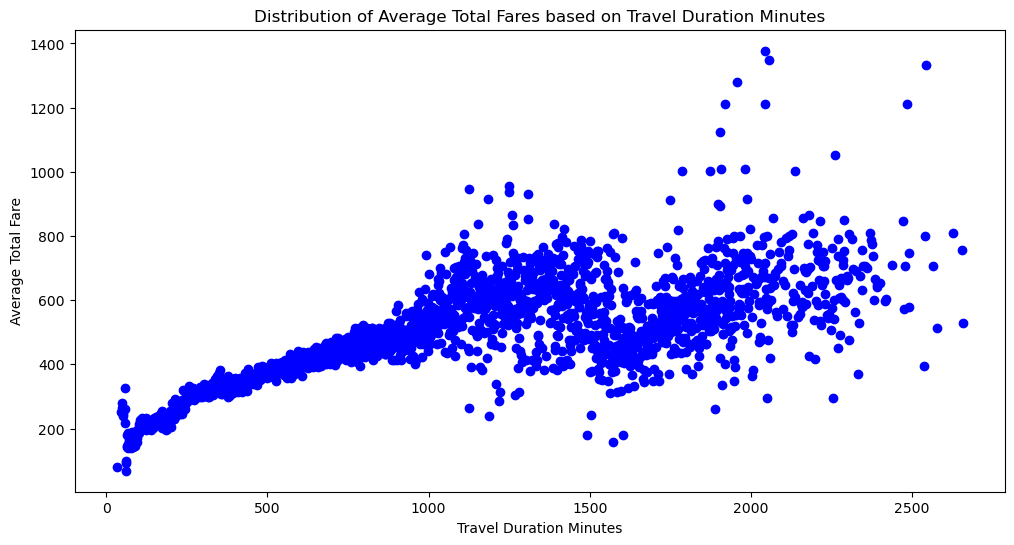

In [29]:
result_df = (price_df.groupBy("travel_duration_minutes")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(12, 6))
plt.scatter(result_df['travel_duration_minutes'], result_df['average_total_fare'], color='blue')
plt.title('Distribution of Average Total Fares based on Travel Duration Minutes')
plt.xlabel('Travel Duration Minutes')
plt.ylabel('Average Total Fare')
plt.show()

Top Values:
   total_distance  num_flights  average_total_fare
0          3342.0          540         2110.372222
1          2170.0          768         1846.135391
2          3505.0           18         1676.831111
3          3510.0            2         1657.100000
4          3440.0            1         1487.100000

Bottom Values:
      total_distance  num_flights  average_total_fare
3241           611.0          145          129.051172
3242           191.0         6778          128.642130
3243           412.0         1776          111.920681
3244           701.0        16909           89.980343
3245           484.0         6956           76.506532


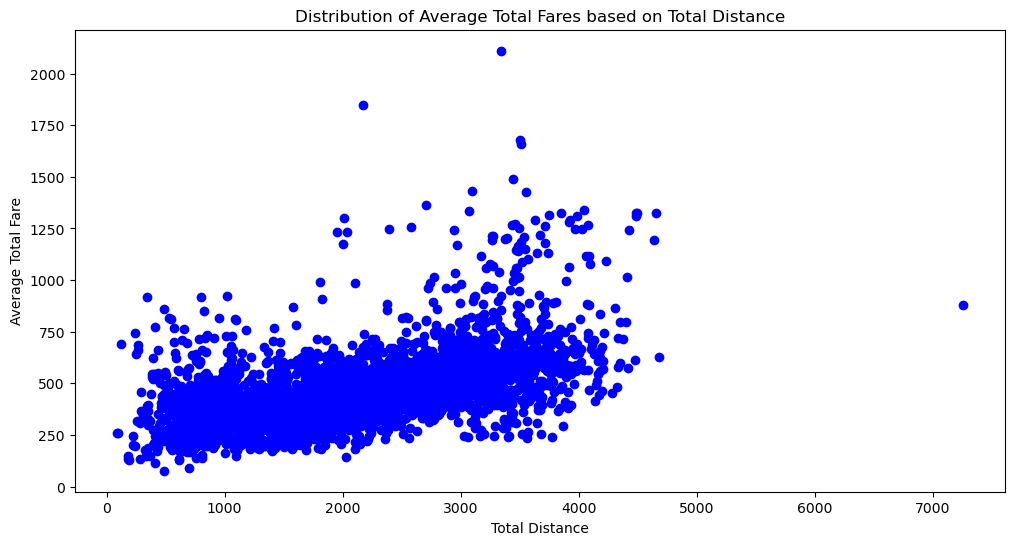

In [30]:
result_df = (price_df.groupBy("total_distance")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(12, 6))
plt.scatter(result_df['total_distance'], result_df['average_total_fare'], color='blue')
plt.title('Distribution of Average Total Fares based on Total Distance')
plt.xlabel('Total Distance')
plt.ylabel('Average Total Fare')
plt.show()

Top Values (Normalized for Travel Distance):
  day_of_week  day_of_week_index  num_flights  average_total_fare  \
0      Sunday                  0     10317627          401.379955   
1      Friday                  5     11660287          360.068603   
2      Monday                  1     11775547          351.629487   
3    Thursday                  4     11959848          346.980622   
4    Saturday                  6     10726349          336.612162   
5   Wednesday                  3     12667367          303.702787   
6     Tuesday                  2     13031728          297.041205   

   normalized_average_total_fare  
0                       0.252042  
1                       0.224855  
2                       0.219597  
3                       0.216556  
4                       0.203771  
5                       0.188830  
6                       0.184142  


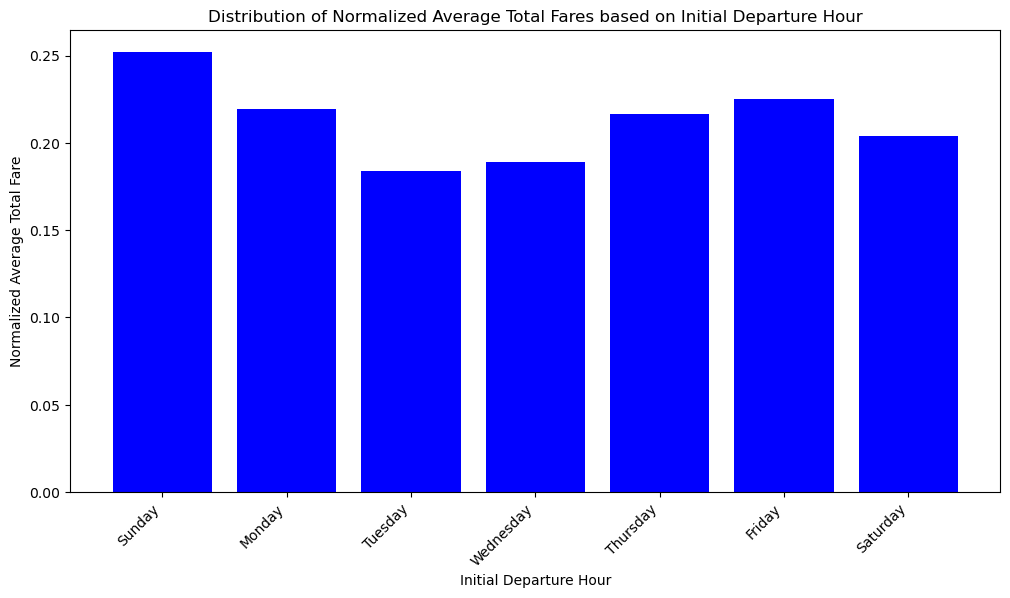

In [32]:
result_df = (price_df.groupBy("day_of_week", "day_of_week_index")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                         (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(7)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

result_df = result_df.sort_values(by='day_of_week_index')

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.bar(result_df['day_of_week'], result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Initial Departure Hour')
plt.xlabel('Initial Departure Hour')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45, ha="right")
plt.show()

Top Values (Normalized for Travel Distance):
   initial_departure_hour  num_flights  average_total_fare  \
0                       7       364219          450.862274   
1                       5      1504311          418.078103   
2                       6      1694361          398.436538   
3                       4       542046          370.573804   
4                      14      5760430          369.964377   

   normalized_average_total_fare  
0                       0.180010  
1                       0.174000  
2                       0.161319  
3                       0.146932  
4                       0.217240  

Bottom Values (Normalized for Travel Distance):
    initial_departure_hour  num_flights  average_total_fare  \
19                      11      5256949          319.541537   
20                       0      2184720          314.991403   
21                      22      3216797          313.119873   
22                      23      3171609          307.528504   
23      

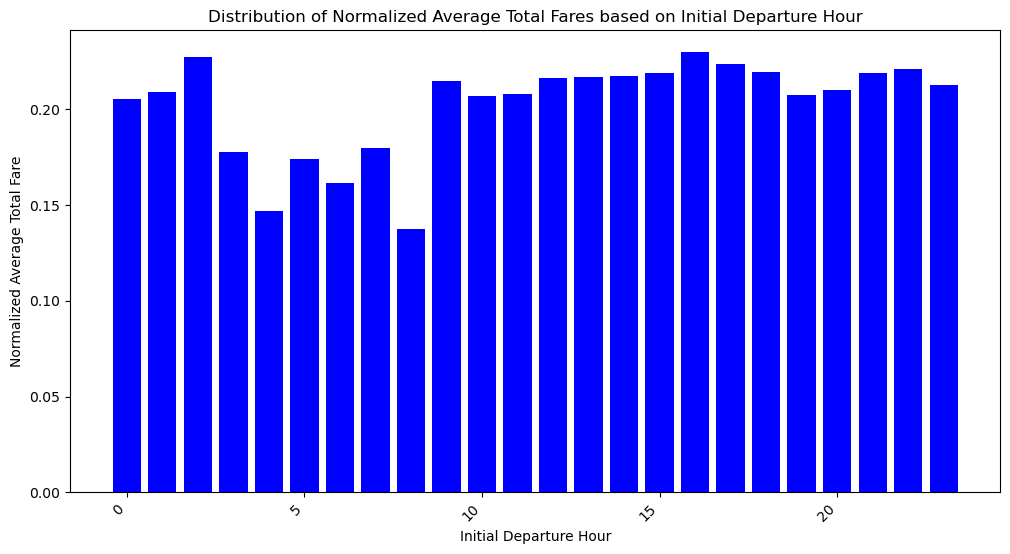

In [33]:
result_df = (price_df.groupBy("initial_departure_hour")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                         (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values (Normalized for Travel Distance):")
print(bottom_values)

result_df = result_df.sort_values(by='initial_departure_hour')

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.bar(result_df['initial_departure_hour'], result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Initial Departure Hour')
plt.xlabel('Initial Departure Hour')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45, ha="right")
plt.show()

Top Values (Normalized for Travel Distance):
   final_arrival_hour  num_flights  average_total_fare  \
0                   6      1898773          461.032988   
1                  10       982649          445.102365   
2                   5      2171862          401.798443   
3                   9       637350          371.118354   
4                   7       752023          370.484972   

   normalized_average_total_fare  
0                       0.186206  
1                       0.196696  
2                       0.187104  
3                       0.154970  
4                       0.155369  

Bottom Values (Normalized for Travel Distance):
    final_arrival_hour  num_flights  average_total_fare  \
19                  14      3578711          308.320284   
20                  12      1604425          305.491673   
21                  13      2324649          302.033363   
22                  16      3882487          300.996018   
23                  17      3760111          297.071

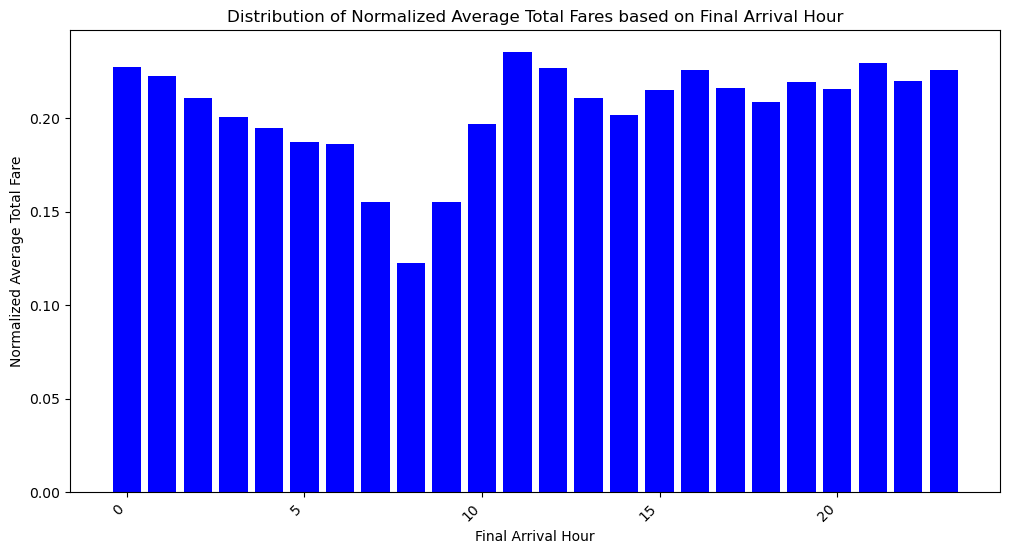

In [34]:
result_df = (price_df.groupBy("final_arrival_hour")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                         (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values (Normalized for Travel Distance):")
print(bottom_values)

result_df = result_df.sort_values(by='final_arrival_hour')

plt.figure(figsize=(12, 6))
plt.bar(result_df['final_arrival_hour'], result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Final Arrival Hour')
plt.xlabel('Final Arrival Hour')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45, ha="right")
plt.show()

Top Values (Normalized for Travel Distance):
  origin  num_flights  average_total_fare  normalized_average_total_fare
0    OAK      3809884          534.211396                       0.214507
1    SFO      5706482          434.504077                       0.186638
2    LAX      8073281          379.254937                       0.170522
3    JFK      4425164          375.406488                       0.254306
4    IAD      3464378          370.046151                       0.271939

Bottom Values (Normalized for Travel Distance):
   origin  num_flights  average_total_fare  normalized_average_total_fare
11    MIA      4930213          299.955595                       0.181319
12    LGA      5919323          299.220774                       0.207633
13    DFW      5674959          294.077856                       0.206042
14    BOS      5883876          285.865775                       0.203508
15    ORD      5503476          281.691875                       0.236375


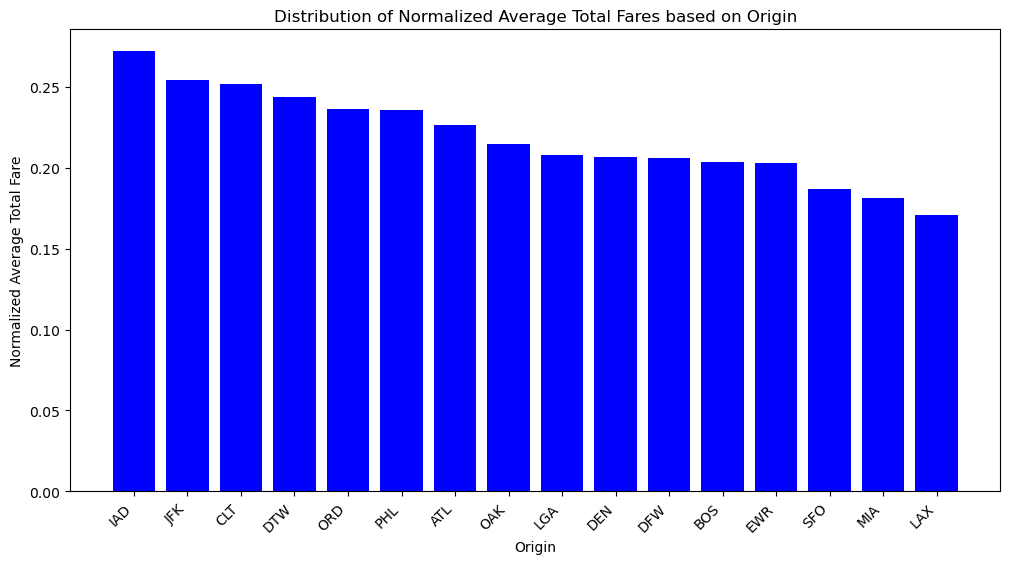

In [35]:
result_df = (price_df.groupBy("origin")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                          (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values (Normalized for Travel Distance):")
print(bottom_values)

result_df = result_df.sort_values(by='normalized_average_total_fare', ascending=False)

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.bar(result_df['origin'], result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Origin')
plt.xlabel('Origin')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45, ha="right")
plt.show()

Top Values (Normalized for Travel Distance):
  destination  num_flights  average_total_fare  normalized_average_total_fare
0         OAK      3657923          530.599937                       0.214563
1         SFO      5586204          418.759590                       0.180651
2         JFK      4413765          371.989837                       0.251853
3         IAD      3312681          367.485806                       0.266005
4         PHL      4703822          357.491675                       0.239096

Bottom Values (Normalized for Travel Distance):
   destination  num_flights  average_total_fare  normalized_average_total_fare
11         DFW      5957280          300.812487                       0.209314
12         BOS      5801538          298.714920                       0.209771
13         LGA      6093450          298.707090                       0.209552
14         MIA      5103390          298.510099                       0.178156
15         ORD      5717699          293.25

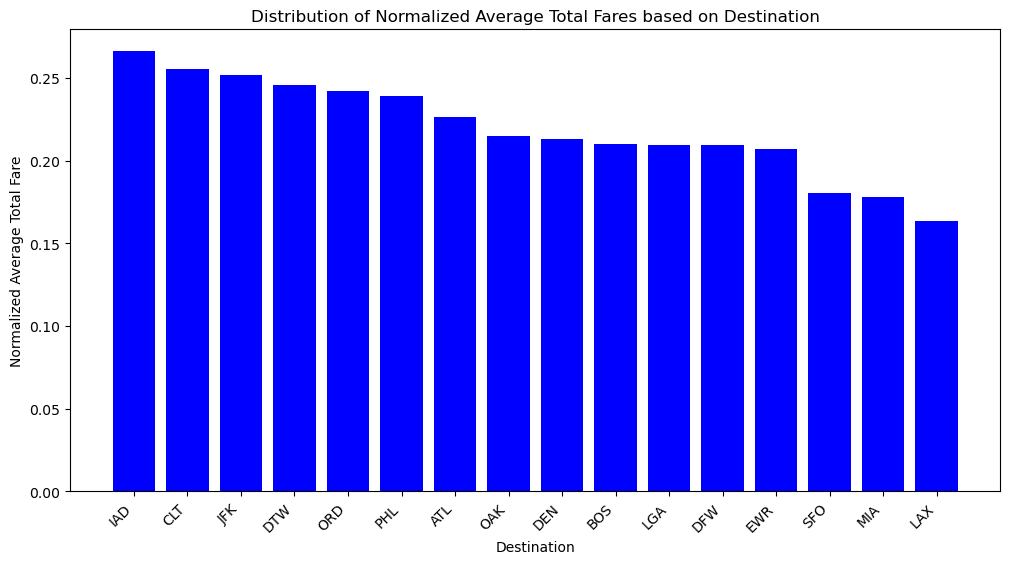

In [36]:
result_df = (price_df.groupBy("destination")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                          (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values (Normalized for Travel Distance):")
print(bottom_values)

result_df = result_df.sort_values(by='normalized_average_total_fare', ascending=False)

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.bar(result_df['destination'], result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Destination')
plt.xlabel('Destination')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45, ha="right")
plt.show()

Top Values (Normalized for Travel Distance):
   num_stops  num_flights  average_total_fare  normalized_average_total_fare
0          4           98          865.807857                       0.222251
1          3       199812          634.349780                       0.555256
2          2      7586488          549.994627                       0.234204
3          1     52285467          346.511574                       0.199786
4          0     22066888          251.148630                       0.232543


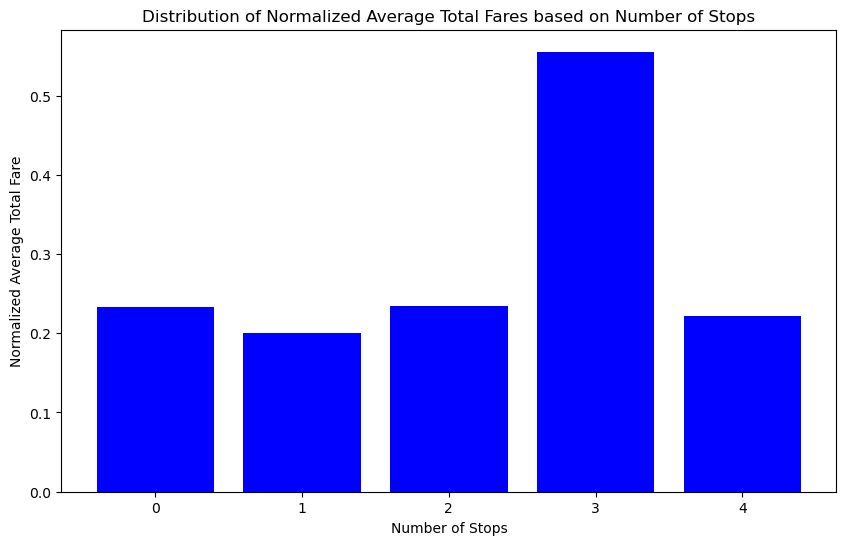

In [37]:
result_df = (price_df.groupBy("num_stops")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                          (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

result_df = result_df.sort_values(by='num_stops')

plt.figure(figsize=(10, 6))
plt.bar(result_df['num_stops'].astype(str), result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()

Top Values:
  origin destination  num_flights  average_total_fare
0    OAK         MIA       182392          664.285197
1    LGA         OAK       402236          657.532472
2    OAK         LGA       377959          655.669618
3    IAD         OAK       169011          655.210961
4    OAK         CLT       205040          649.146361

Bottom Values:
    origin destination  num_flights  average_total_fare
230    EWR         BOS       216598          172.807808
231    BOS         EWR       209469          170.949851
232    EWR         LGA           23          151.424348
233    BOS         LGA       483784          143.128716
234    LGA         BOS       442019          140.151673


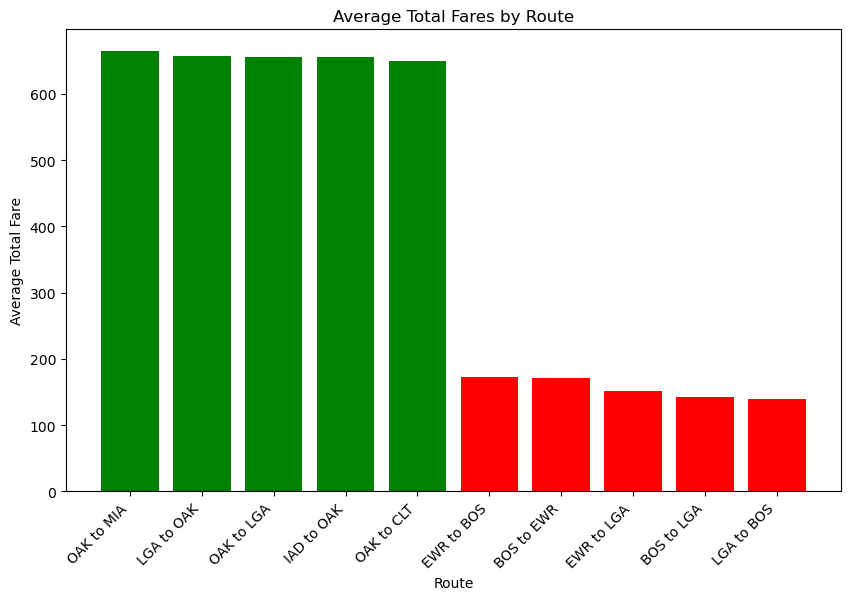

In [38]:
result_df = (price_df.groupBy("origin", "destination")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(10, 6))
plt.bar(top_values['origin'] + ' to ' + top_values['destination'], top_values['average_total_fare'], color='green', label='Top Average Total Fares')
plt.bar(bottom_values['origin'] + ' to ' + bottom_values['destination'], bottom_values['average_total_fare'], color='red', label='Bottom Average Total Fares')
plt.title('Average Total Fares by Route')
plt.xlabel('Route')
plt.ylabel('Average Total Fare')
plt.xticks(rotation=45, ha='right')
plt.show()

Top Values (Normalized for Travel Distance):
  origin destination  num_flights  average_total_fare  normalized_total_fare
0    JFK         BOS       344212          201.792282               0.830640
1    EWR         LGA           23          151.424348               0.810193
2    BOS         JFK       341232          194.788028               0.807472
3    ATL         CLT       233173          303.545420               0.701713
4    ORD         DTW       156515          220.324111               0.685764

Bottom Values (Normalized for Travel Distance):
    origin destination  num_flights  average_total_fare  normalized_total_fare
230    DFW         LGA       501460          216.854222               0.150440
231    EWR         SFO       366756          407.325363               0.150374
232    BOS         LAX       644390          394.647855               0.147118
233    MIA         LAX       491611          346.772079               0.143919
234    EWR         LAX       544467          355.

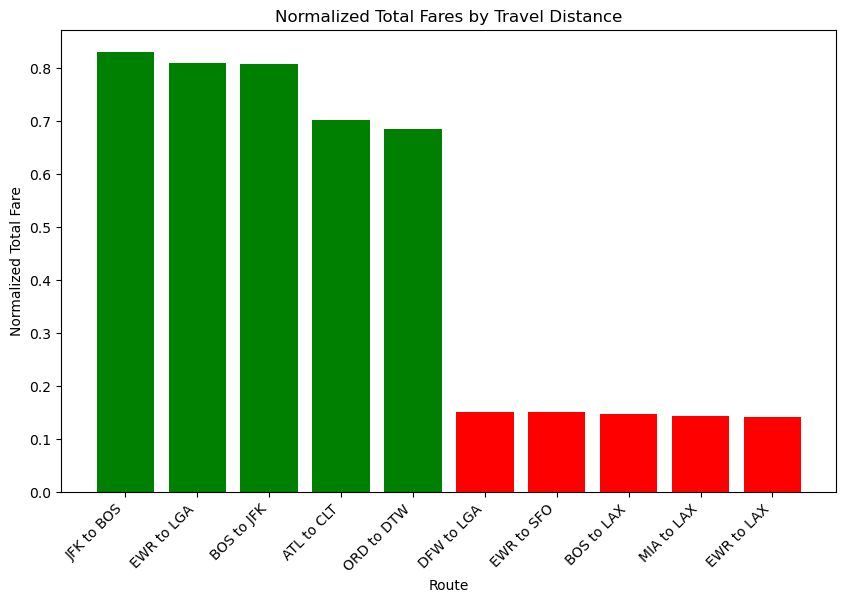

In [39]:
price_df = price_df.withColumn('normalized_total_fare', col('total_fare') / col('total_distance'))

result_df_normalized = (price_df.groupBy("origin", "destination")
                                .agg(count("total_fare").alias("num_flights"),
                                     mean("total_fare").alias("average_total_fare"),
                                     mean("normalized_total_fare").alias("normalized_total_fare"))
                                .orderBy("normalized_total_fare", "num_flights", ascending=[False, False])
                                .toPandas())

# Display top and bottom values
top_values_normalized = result_df_normalized.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values_normalized)

bottom_values_normalized = result_df_normalized.tail(5)
print("\nBottom Values (Normalized for Travel Distance):")
print(bottom_values_normalized)

plt.figure(figsize=(10, 6))
plt.bar(top_values_normalized['origin'] + ' to ' + top_values_normalized['destination'], top_values_normalized['normalized_total_fare'], color='green')
plt.bar(bottom_values_normalized['origin'] + ' to ' + bottom_values_normalized['destination'], bottom_values_normalized['normalized_total_fare'], color='red')
plt.title('Normalized Total Fares by Travel Distance')
plt.xlabel('Route')
plt.ylabel('Normalized Total Fare')
plt.xticks(rotation=45, ha='right')
plt.show()

Top Values (Normalized for Travel Distance):
   is_nonstop  num_flights  average_total_fare  normalized_average_total_fare
0       False     60071865          373.167749                       0.205612
1        True     22066888          251.148630                       0.232543


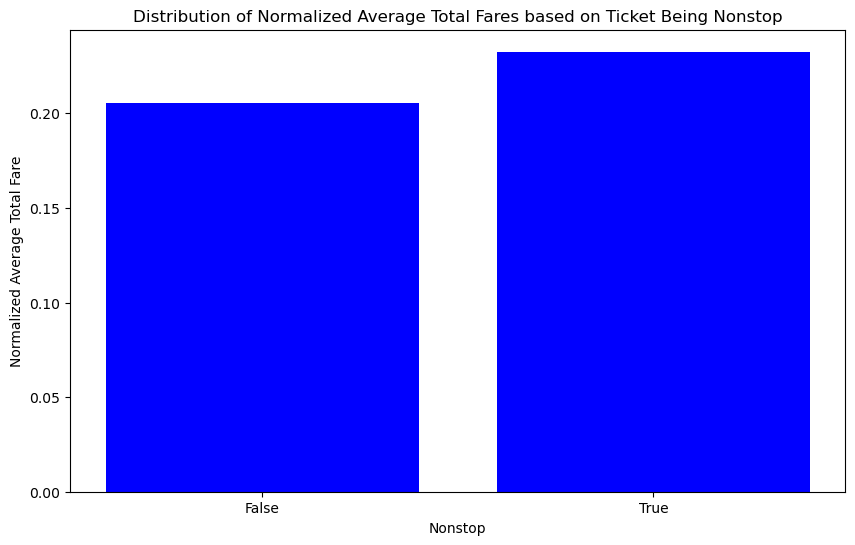

In [40]:
result_df = (price_df.groupBy("is_nonstop")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                          (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

result_df = result_df.sort_values(by='is_nonstop')

plt.figure(figsize=(10, 6)) 
plt.bar(result_df['is_nonstop'].astype(str), result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Ticket Being Nonstop')
plt.xlabel('Nonstop')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()

Top Values (Normalized for Travel Distance):
   is_refundable  num_flights  average_total_fare  \
0           True         1332         1290.018911   
1          False     82137421          340.371449   

   normalized_average_total_fare  
0                       0.888106  
1                       0.211423  


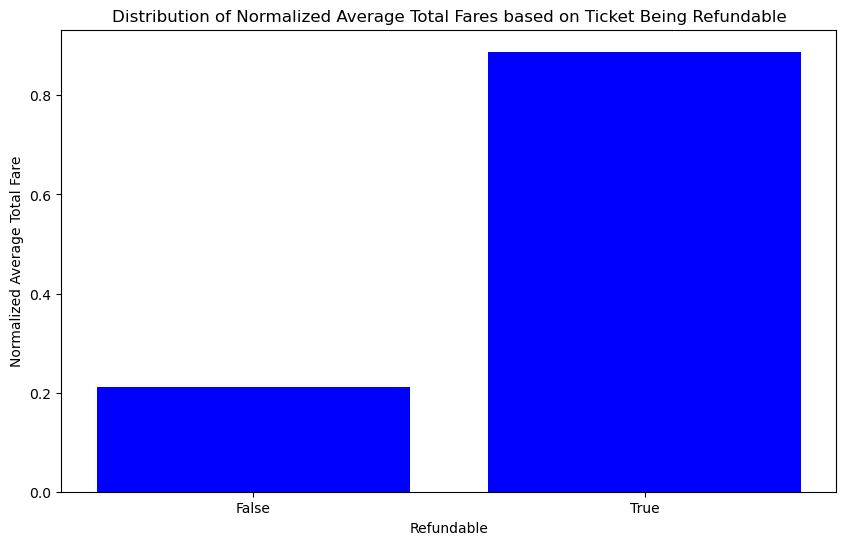

In [41]:
result_df = (price_df.groupBy("is_refundable")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                          (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

result_df = result_df.sort_values(by='is_refundable')

plt.figure(figsize=(10, 6))
plt.bar(result_df['is_refundable'].astype(str), result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Ticket Being Refundable')
plt.xlabel('Refundable')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()

Top Values (Normalized for Travel Distance):
   is_basic_economy  num_flights  average_total_fare  \
0             False     70313487          367.551092   
1              True     11825266          178.867216   

   normalized_average_total_fare  
0                       0.223304  
1                       0.126603  


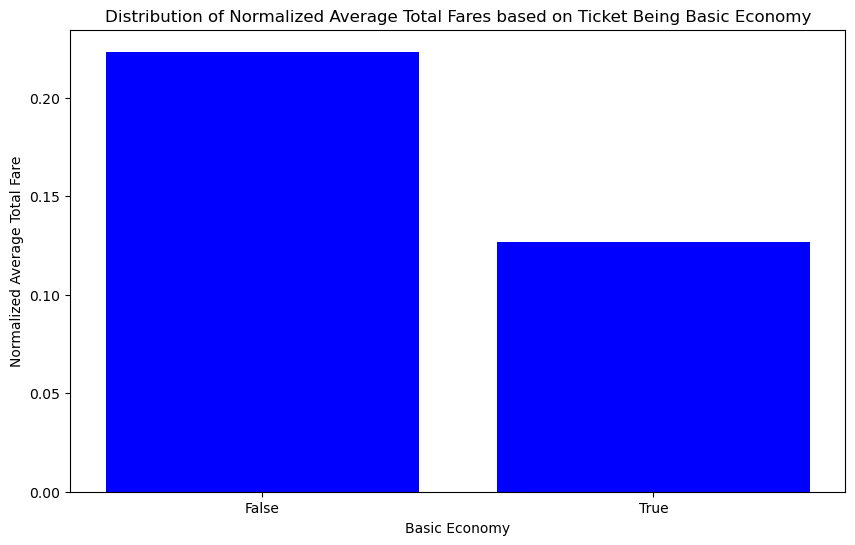

In [42]:
result_df = (price_df.groupBy("is_basic_economy")
                     .agg(count("total_fare").alias("num_flights"), 
                          mean("total_fare").alias("average_total_fare"),
                          (mean("total_fare") / mean("total_distance")).alias("normalized_average_total_fare"))
                     .orderBy("average_total_fare", "num_flights", ascending=[False, False])
                     .toPandas())

top_values = result_df.head(5)
print("Top Values (Normalized for Travel Distance):")
print(top_values)

result_df = result_df.sort_values(by='is_basic_economy')

plt.figure(figsize=(10, 6))
plt.bar(result_df['is_basic_economy'].astype(str), result_df['normalized_average_total_fare'], color='blue')
plt.title('Distribution of Normalized Average Total Fares based on Ticket Being Basic Economy')
plt.xlabel('Basic Economy')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()